# Model Selection 
___

**Objective:** Select a model that can achieve a Mean Absolute Error of up to R$ 500 in mothly income prediction.  
 
- **MAE** was selected as the metric because it is easy to interpret and appropriate for the salary scenario.   
- The threshold of **R$ 500** was selected because it is reasonable for the data range and adds up to a prediction margin of R$ 1,000.   

**Process:**

1. Import libraries, modules, functions, classes, and the dataset
2. Train a baseline model and evaluate its performance
    - I'll use a default Random Forest because I think the reasoning to determine salary is similar to a tree-thought process.
    - Although it has robust internal mechanisms to generalize predictions, everytime I run the code, I'll test a different parameter that seems appropriate and will note fit time and performance
3. Train and optmize a boosting method to compare against bagging
    - I'll start with LightGBM because it's faster.
    - If necessary, I can use XGBoost or CatBoost
4. Evaluate whether a combination of models will work better than a single model
____

## 1. Importing

In [ ]:
# Adding src to the path for modules
import sys
import os
root_path = os.path.abspath('..')
src_path = os.path.join(root_path, 'src')
sys.path.append(src_path)

# Project variables and functions
import config 
import utils
from preprocessing import pre_processing, divide_train_test
import importlib
importlib.reload(utils)

# Data manipulation
import pandas as pd
import numpy as np

# Models and metrics
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV


Importing and dividing the data:

In [2]:
# Imports data and divide it into training and testing
X_train, X_test, y_train, y_test = divide_train_test(
    utils.read_compressed_data(config.COLLECTED_DATA_PATH),
    config.FEATURES,
    config.TARGET
)

# Shows first lines on X_train
X_train.head()

,state,age,sex,race,literate,highest_educational_level,years_studied,worker_type,work_segment,occupation_group,tax_payer,weekly_worked_hours,weekly_worked_hours_all_jobs
206997,DF,57,2,4,1,3,9,4,11,9,2,3,40
653228,CE,33,1,4,1,7,16,7,8,2,1,3,40
596722,PR,22,2,1,1,6,13,1,7,4,1,3,40
322304,BA,24,1,4,1,5,12,1,10,5,1,4,48
121644,AM,45,1,1,1,2,6,9,5,8,2,4,45


___

## 2. Baseline Model (Random Forest):

Notes:
- RandomForestRegressor(random_state=0) takes 7 min to fit and achieve a 790 MAE with 50% R²
- RandomForestRegressor(random_state=0, n_estimators=400) takes 40 min to fit and achieve a 786 MAE with 51% R²
- RandomForestRegressor(random_state=0, max_depth=8) takes 3 min to fit and achieve a 860 MAE with 45% R2
- RandomForestRegressor(random_state=0, max_depth=32) takes 8 min to fit and achieve a 788 MAE with 51% R²
- RandomForestRegressor(random_state=0, max_depth=24) takes 10 min to fit and achieve a 785 MAE with 52% R²
- RandomForestRegressor(random_state=0, min_samples_split=8) takes 6 min to fit and achieve a 787 MAE with 52% R²

In [3]:
# Creates a baseline pipeline using default random forest
baseline = Pipeline(
    steps=[
        ('pre_processing', pre_processing),
        ('model', RandomForestRegressor(random_state=0, min_samples_split=16))
    ]
)

# Fits 
baseline.fit(X_train, y_train)

Pipeline(steps=[('pre_processing',
                 Pipeline(steps=[('add region',
                                  AddFeature(existing_column='state',
                                             function=<function return_region at 0x000002D3163AB310>,
                                             new_feature_name='region')),
                                 ('add white mixed-race',
                                  AddFeature(existing_column='race',
                                             function=<function return_white_mixed_race at 0x000002D3163AB9D0>,
                                             new_feature_name='white_mixed_race')),
                                 ('add high schoo...
                                             function=<function discretize_weekly_worked_hours_all_jobs at 0x000002D3163AB8B0>,
                                             new_feature_name='weekly_worked_hours_v2')),
                                 ('add studied years',
                                  AddFeature(existing_column='years_studied',
                                             function=<function discretize_years_studied at 0x000002D3163AB940>,
                                             new_feature_name='studied_years_v2')),
                                 ('target encoder',
                                  TargetEncoder(cols=['state']))])),
                ('model',
                 RandomForestRegressor(min_samples_split=16, random_state=0))])

Evaluating Feature Importance:

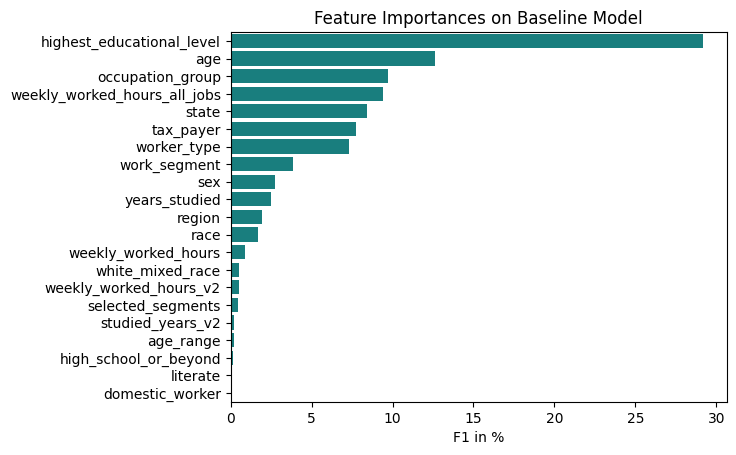

In [4]:
# Understand feature importances

# Starts with original features
features = list(X_train.columns)

# Appends new features
for i in range(len(baseline['pre_processing'])-1):
    features.append(baseline['pre_processing'][i].get_params()['new_feature_name'])

# Obtains feature importances and multiply by 100 to make a percentage
fi = np.array(baseline['model'].feature_importances_) * 100

# Combines everything in a Series
fi_series = pd.Series(fi, index=features)

# Sorts fi_series
fi_series.sort_values(ascending=False, inplace=True)

# Plots ranking
utils.show_barplot(
    cat=fi_series.index,
    values=fi_series,
    title='Feature Importances on Baseline Model',
    x_label='F1 in %'
)

Evaluating predictions with MAE and other complementary metrics:

In [5]:
baseline_pred = baseline.predict(X_test)

print(f'MSE: {mean_squared_error(y_test, baseline_pred)}')
print(f'MAE: {mean_absolute_error(y_test, baseline_pred)}')
print(f'R²: {utils.make_percentage(r2_score(y_test, baseline_pred))}')

MSE: 1558381.9046386273
MAE: 782.8445187626401
R²:  53.10%


**In Summary:**
- A simple Random Forest performs relatively well, but does not achieve the expected MAE.
- Some features almost have no importance to the algorithm as it extracts more information from the original variables than the created ones.
___

## 3. Boosting Method (LightGBM)

Notes:
- LGBMRegressor(random_state=0) fits in 7 seconds, and achieves a 811 MAE with 50% R²
- Optmization for LGBMRegressor took 17 minutes to find the best estimator to have 200 estimators, 100 leaves, MAE 795, and R² of 52%.
- LGBMRegressor(random_state=0, n_estimators=300, num_leaves=100, force_row_wise=True) fits in 19 seconds, and achieves a 793 MAE with R² of 52%.

In [6]:
# Creates a pipeline
lgbm_pipeline = Pipeline(
    steps=[
        ('pre_processing', pre_processing),
        ('model', LGBMRegressor(random_state=0, n_estimators=500, num_leaves=200, force_row_wise=True))
    ]
)

# Fits
lgbm_pipeline.fit(X_train, y_train)

[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 578261, number of used features: 21
[LightGBM] [Info] Start training from score 2201.854054


Pipeline(steps=[('pre_processing',
                 Pipeline(steps=[('add region',
                                  AddFeature(existing_column='state',
                                             function=<function return_region at 0x000002D3163AB310>,
                                             new_feature_name='region')),
                                 ('add white mixed-race',
                                  AddFeature(existing_column='race',
                                             function=<function return_white_mixed_race at 0x000002D3163AB9D0>,
                                             new_feature_name='white_mixed_race')),
                                 ('add high schoo...
                                             new_feature_name='weekly_worked_hours_v2')),
                                 ('add studied years',
                                  AddFeature(existing_column='years_studied',
                                             function=<function discretize_years_studied at 0x000002D3163AB940>,
                                             new_feature_name='studied_years_v2')),
                                 ('target encoder',
                                  TargetEncoder(cols=['state']))])),
                ('model',
                 LGBMRegressor(force_row_wise=True, n_estimators=500,
                               num_leaves=200, random_state=0))])

In [7]:
lgbm_pred = lgbm_pipeline.predict(X_test)

print(f'MSE: {mean_squared_error(y_test, lgbm_pred )}')
print(f'MAE: {mean_absolute_error(y_test, lgbm_pred )}')
print(f'R²: {utils.make_percentage(r2_score(y_test, lgbm_pred ))}')

MSE: 1548075.6026395012
MAE: 782.073329944892
R²:  53.41%


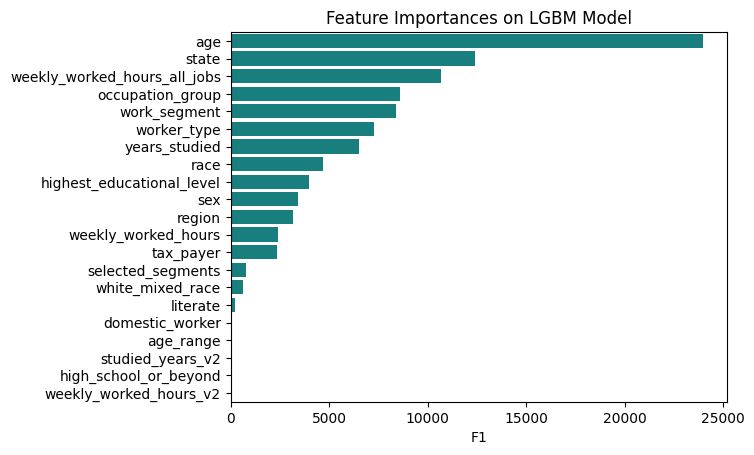

In [8]:
# Obtains feature importances and multiply by 100 to make a percentage
lgbm_fi = np.array(lgbm_pipeline['model'].feature_importances_)

# Combines everything in a Series
lgbm_fi_series = pd.Series(lgbm_fi, index=features)

# Sorts fi_series
lgbm_fi_series.sort_values(ascending=False, inplace=True)

# Plots ranking
utils.show_barplot(
    cat=lgbm_fi_series.index,
    values=lgbm_fi_series,
    title='Feature Importances on LGBM Model',
    x_label='F1'
)

Optmizing LightGBM with GridSearchCV as it has short fit time:

In [ ]:
# Creates a param_grid
lgbm_params = {
    'model__learning_rate': [0.08, 0.1],
    'model__n_estimators': [500, 1000],
    'model__num_leaves': [200, 250],
    'model__force_row_wise': [True],
    'model__reg_alpha': [0, 0.1, 1]
}

# Creates the GridSearch
lgbm_grid_search = GridSearchCV(lgbm_pipeline, lgbm_params, cv=4, n_jobs=-1, scoring='neg_mean_absolute_error')

#Fits
lgbm_grid_search.fit(X_train, y_train)

In [17]:
# Understaning best model params
best_lgbm = lgbm_grid_search.best_estimator_
best_lgbm['model'].get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'num_leaves': 100,
 'objective': None,
 'random_state': 0,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'force_row_wise': True}

In [18]:
lgbm_pred = best_lgbm.predict(X_test)

print(f'MSE: {mean_squared_error(y_test, lgbm_pred )}')
print(f'MAE: {mean_absolute_error(y_test, lgbm_pred )}')
print(f'R²: {utils.make_percentage(r2_score(y_test, lgbm_pred ))}')

MSE: 1591379.4303732717
MAE: 795.3111452950363
R²:  52.10%


**In Summary:**
- LightGBM was fast, but did not achieve expected MAE or performed better than Random Forest
- Further optmization can possibly be achieved increasing learning rate, n_estimators or num_leaves
_____

## 4. Combining Models

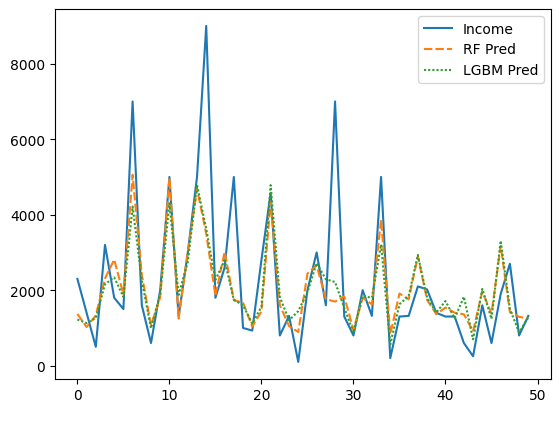

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns


# Sampling n observations
n = 50
sample = X_test.sample(n, random_state=0)
sample_y = y_test[sample.index]

# Predicting using models
rf_sample_pred = baseline.predict(sample)
lgbm_sample_pred = lgbm_pipeline.predict(sample)

# Constructs a DataFrame to compare
sample_pred_df = pd.DataFrame({'Income': sample_y, 'RF Pred': rf_sample_pred, 'LGBM Pred': lgbm_sample_pred})
sample_pred_df.index = list(range(n))
ax = sns.lineplot(data=sample_pred_df)
ax.set_xlabel(' ')
plt.show()

The predictions follow tha variance in income.   
I'll measure the MAE per each thousand R$:

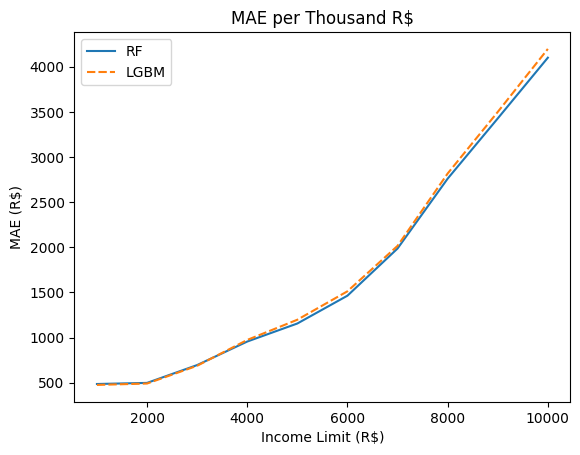

In [17]:
rf_maes = {}
lgbm_maes = {}

for income_limit in range(1000, 11000, 1000):
    # Diving y_test/x_test in segments of thousand R$
    if income_limit == 1000:
        initial_limit = 0
    else:
        initial_limit = income_limit - 999
    
    income_segment_bool = (y_test >= initial_limit) & (y_test < income_limit)
    income_segment_indexes = list(y_test[income_segment_bool].index)
    y_test_divided = y_test[income_segment_indexes]
    X_test_divided = X_test.loc[income_segment_indexes]

    # Predicting on X_test_divided
    rf_pred = baseline.predict(X_test_divided)
    lgbm_pred = lgbm_pipeline.predict(X_test_divided)

    # Storing maes
    rf_maes[income_limit] = mean_absolute_error(y_test_divided, rf_pred)
    lgbm_maes[income_limit] = mean_absolute_error(y_test_divided, lgbm_pred)

# Analyse MAES
maes_per_thousand = pd.DataFrame({'RF': list(rf_maes.values()), 'LGBM': list(lgbm_maes.values())}, index=list(rf_maes.keys()))
ax = sns.lineplot(maes_per_thousand)
plt.title('MAE per Thousand R$')
ax.set_ylabel('MAE (R$)')
ax.set_xlabel('Income Limit (R$)')
plt.show()


The greater the income, less acurate both models are at predicting.   
Interestingly, a 500 MAE is achieved within the first 2,000 R$

RF MAE: 782.8445187626401
LGBM MAE: 782.073329944892


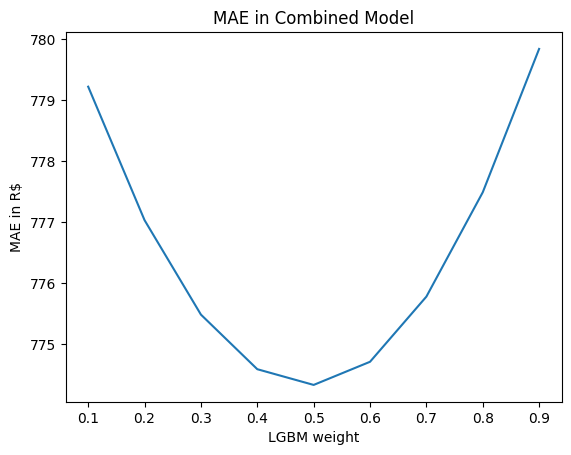

In [21]:
lgbm_pred = lgbm_pipeline.predict(X_test)

print(f'RF MAE: {mean_absolute_error(y_test, baseline_pred)}')
print(f'LGBM MAE: {mean_absolute_error(y_test, lgbm_pred)}')

results = {}

# Initialize looping and changing rf_weight
for rf_weight in range(9, 0, -1):
    rf_weight = rf_weight / 10
    lgbm_weight = 1 - rf_weight

    weighted_pred = baseline_pred * rf_weight + lgbm_pred * lgbm_weight
    results[rf_weight] = mean_absolute_error(y_test, weighted_pred)

ax = sns.lineplot(data=results)
plt.title('MAE in Combined Model')
ax.set_ylabel('MAE in R$')
ax.set_xlabel('LGBM weight')
plt.show()


In [22]:
from sklearn.ensemble import StackingRegressor

stacked = StackingRegressor(
    estimators=[
        ('rf', RandomForestRegressor(random_state=0, min_samples_split=16))
    ], 
    final_estimator = LGBMRegressor(random_state=0, n_estimators=300, force_row_wise=True, num_leaves=200)
)

stacked_pipeline = Pipeline(
    steps=[
        ('pre_processing', pre_processing),
        ('model', stacked)
    ]
)

stacked_pipeline.fit(X_train, y_train)


[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 578261, number of used features: 1
[LightGBM] [Info] Start training from score 2201.854054


Pipeline(steps=[('pre_processing',
                 Pipeline(steps=[('add region',
                                  AddFeature(existing_column='state',
                                             function=<function return_region at 0x000002D3163AB310>,
                                             new_feature_name='region')),
                                 ('add white mixed-race',
                                  AddFeature(existing_column='race',
                                             function=<function return_white_mixed_race at 0x000002D3163AB9D0>,
                                             new_feature_name='white_mixed_race')),
                                 ('add high schoo...
                                             function=<function discretize_years_studied at 0x000002D3163AB940>,
                                             new_feature_name='studied_years_v2')),
                                 ('target encoder',
                                  TargetEncoder(cols=['state']))])),
                ('model',
                 StackingRegressor(estimators=[('rf',
                                                RandomForestRegressor(min_samples_split=16,
                                                                      random_state=0))],
                                   final_estimator=LGBMRegressor(force_row_wise=True,
                                                                 n_estimators=300,
                                                                 num_leaves=200,
                                                                 random_state=0)))])

In [23]:
stacked_pred = stacked_pipeline.predict(X_test)

print(f'MSE: {mean_squared_error(y_test, stacked_pred )}')
print(f'MAE: {mean_absolute_error(y_test, stacked_pred)}')
print(f'R²: {utils.make_percentage(r2_score(y_test, stacked_pred ))}')

MSE: 1557833.7753717778
MAE: 779.4627905694883
R²:  53.11%
